## Implementation of custom loss functions

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Function 1: Road Loss

In [41]:
from losses import *

In [42]:
x = np.linspace(0,40)
x1 = np.linspace(-40,0)

k2 = 40
k1 = 5

In [43]:
y = np.exp(-x1*(np.log(2))/k2)
y2 = np.exp(-1*x**2/k1)

Text(0, 0.5, 'Loss')

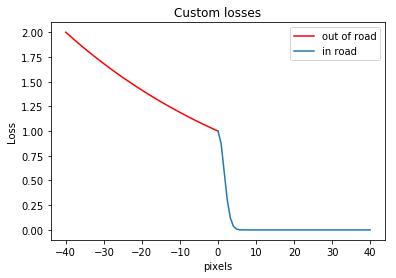

In [44]:
plt.plot(x1, y, label='out of road', c='r')
plt.plot(x, y2, label='in road')
plt.legend()
plt.title('Custom losses')
plt.xlabel('pixels')
plt.ylabel('Loss')

### Function 2: Collision Loss 

In [45]:
import cv2
import math
from numpy import matlib

def binary2bgr(map_mask):
    '''Convert binary HD map to 3-channel image (numpy array)
    
    '''
    mask = Image.fromarray(map_mask.mask())
    mask = np.array(mask)
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)


def polygon_from_ego(center, angle, l=17.3, w=41.0):
    '''Create a CV2 drawable polygon from current egopose.
    ego_map: dictionary of current egopose (px,py,angle)
    w, l: Vehicle width and lenght, by default Renault ZOE's dimesions.
    
    Returns: drawable cv2 polygon
    '''
    # Unpacking egopose as center of the vehicle (original map)
    cx, cy = center
    angle = angle

    # Convert heading angle to radians
    theta = math.radians(angle)

    # Generate corners of the bounding box
    bbox = matlib.repmat([[cx], [cy]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w / 2, w / 2, w / 2, -w / 2, w / 2 + 8],
                  [-l / 2, -l / 2, l / 2, l / 2, 0]])
    
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]
    
    polygon = [x1, y1, x2, y2, x3, y3, x4, y4]
          
    return np.array(polygon).reshape((-1,1,2)).astype(np.int32)


def draw_egopose(polygon, overlay, angle, speed):
    '''Draw box with speed channel. Crops the map on a square centered on ego, transform the original box
    coordinates to new reference (only translation, not rotation)
    box: box dictionary to draw
    map_mask & map_mask: full sized (original) map
    ego: Coordinates of ego in the current frame (reference to original map)
    field_view: limit of visibility as pixels around ego
    speed: non-normalized speed of the current actor (ms, degrees)
    ann:  Annotate speed of actor or not
    '''
    # For human readable colors
    b = 255
    g = int((speed/40)*255)
    r = int((angle/360)*255)
    
    # Draw the box
    cv2.drawContours(overlay, [polygon], 0, (b,g,r), -1)

    return overlay


In [46]:
# Create a black canvas
canvas = np.zeros((150,150,3))

# Create a bounding box / use Renault Zoe dimensions
polygon = polygon_from_ego(center=(75,75), angle=75, l=17.3, w=41.0)

# Draw polygon on canvas
img = draw_egopose(polygon, canvas, angle=75, speed=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


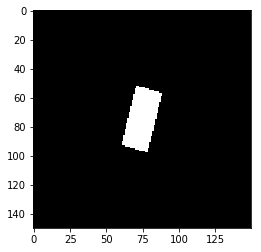

In [47]:
plt.imshow(img)

In [48]:
def makeGaussian(canvas_size, center, height, sigma_X, sigma_Y, theta, resolution=0.1):
    '''Make a 2D Gaussian function
    canvas_size: Tuple if image size, example (64,64)
    center: Tuple of bounding bow center in XY coordinates
    heigh: Maximum value of the gaussian at bounding box center
    sigma_x, sigma_y: bounding box position uncertainty in x,y axis
    theta: bounding box angle in radians
    resolution: resolution of function mesh, default 0.1 pixels
    '''
    x_max, y_max = canvas_size[0], canvas_size[1]
    x0, y0 = center
    
    # Create function mesh
    x = np.arange(0, x_max, resolution)
    y = np.arange(0, y_max, resolution)
    X, Y = np.meshgrid(x, y, sparse=True)
    
    # Calculate ellipse parameters
    a = (np.cos(theta)**2/(2*sigma_X**2)) + (np.sin(theta)**2/(2*sigma_Y**2))
    b = (-1*np.sin(2*theta)/(4*sigma_X**2)) + (np.sin(2*theta)/(4*sigma_Y**2))
    c = (np.sin(theta)**2/(2*sigma_X**2)) + (np.cos(theta)**2/(2*sigma_Y**2))

    # Calculate exponential 
    g = -1*(a*(X-x0)**2 + 2*b*(X-x0)*(Y-y0) + c*(Y-y0)**2)

    return height*np.exp(g)
    
    
def makeBox(canvas_size, center, angle, l=17.3, w=41.1, speed=5):
    '''Generate a black canvas with a bouding box
    canvas_size: Tuple (64,64) or (64,64,3)
    center: Tuple absolute ego coordinates (65,65)
    angle: Heading angle of the bounding box in degrees
    l: lenght of the bouding box in pixels
    w: widht of the bounding box  in pixels
    speed: speed of the bounding box
    '''
    # Create a black canvas
    canvas = np.zeros(canvas_size)

    # Create a bounding box / use Renault Zoe dimensions
    polygon = polygon_from_ego(center, angle, l, w)

    # Draw polygon on canvas
    return draw_egopose(polygon, canvas, angle, speed)


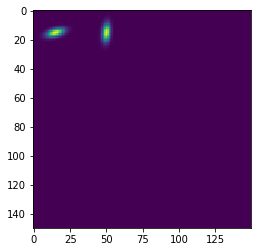

In [49]:
# Generate custom gaussian
g = makeGaussian(canvas_size=(150,150), center=(15,15), 
                 height= 1, sigma_X=4.11, sigma_Y=1.77,
                 theta=np.radians(15), resolution=1)

g2 = makeGaussian(canvas_size=(150,150), center=(50,15), 
                 height= 1, sigma_X=4.11, sigma_Y=1.77,
                 theta=np.radians(85), resolution=1)

plt.imshow(g+g2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


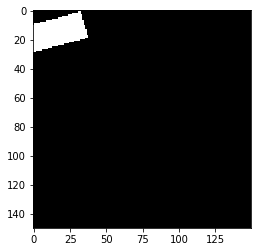

In [50]:
# Generate custom bounding box
im = makeBox(canvas_size=(150,150,3), center=(15,15),
           angle=15, l=17.3, w=41.1, speed=5)

plt.imshow(im)

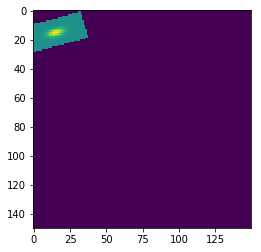

In [51]:
plt.imshow(im[:,:,0] + g*255)

## Torch implementation

In [52]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [53]:
class GaussianLoss(nn.Module):
    '''Calculate collision Loss between ego and a bounding box.
    
    map_size: Image size Tuple example (150,150)
    height: Max value of the loss at the center of a bounding box
    step: Step resolution to calculate loss. Default 1 pixel
    narrow: Reduce variance of the Gaussian by 2 (95%). Default False
    plot: Plot the resulting loss function. Default False
    
    '''
    def __init__(self, map_size, height, step=1, narrow=False, plot=False):
        super().__init__()
        self.height = height 
        self.narrow = narrow
        self.plot = plot
        # Create a mesh gride of map size
        grid = torch.meshgrid([torch.arange(0, map_size[0], step),
                                 torch.arange(0, map_size[1], step)])
        # Torch meshgrid output is not the same as numpy  / correction
        self.grid = [grid[0][:,0].reshape(1,-1).float().to(device), 
                     grid[0][:,0].reshape(1,-1).t().float().to(device)]
    
    def forward(self, prediction, boxes):
        # Calculate a 2D Gaussian loss grid for each actor in the scene
        losses = []
        for box in boxes:
            # Unpack actor bounding box
            x0, y0 = torch.tensor(box['coordinates']).float().to(device)  # non normalized coordinates
            theta = torch.tensor(box['angle']).float().to(device) # In radians
            # We use the bounding box size as covariance in each axis
            sigma_X, h, sigma_Y = torch.tensor(box['whl']).float().to(device)  # box WHL in pixels
            
            if self.narrow:
                sigma_X = sigma_X/2
                sigma_Y = sigma_Y/2
            
            # Generate 2D-Gaussian loss custom parameters
            a = (torch.cos(theta)**2/(2*sigma_X**2)) + (torch.sin(theta)**2/(2*sigma_Y**2))
            b = (-1*torch.sin(2*theta)/(4*sigma_X**2)) + (torch.sin(2*theta)/(4*sigma_Y**2))
            c = (torch.sin(theta)**2/(2*sigma_X**2)) + (torch.cos(theta)**2/(2*sigma_Y**2))
            g = -1*(a*(self.grid[0]-x0)**2 + 2*b*(self.grid[0]-x0)*(self.grid[1]-y0) + c*(self.grid[1]-y0)**2)
            losses.append(self.height*torch.exp(g))
            
        # The final loss function is the superposition of individual losses    
        loss_function = torch.stack(losses, dim=0).sum(dim=0)
        
        if self.plot:
            plt.imshow(loss_function)
            for point in prediction:
                plt.scatter(point[0], point[1], marker='x', c='r')

        # For each prediction point estimate the loss due to each obstacle
        loss = [loss_function[point[1], point[0]] for point in prediction]
        print(loss)
        return torch.tensor(loss).mean()


In [54]:
l = GaussianLoss(map_size=(150,150), height=1, step=1, narrow=True, plot=True)

In [55]:
predictions = [(75, 75), (75, 60), (75, 50), (75, 40), (75, 30), (75, 15)]

predictions

[(75, 75), (75, 60), (75, 50), (75, 40), (75, 30), (75, 15)]

In [56]:
box1 = {'coordinates':(75,75),
       'angle': math.radians(0),
       'whl': (4.11, 2.0, 1.77),
       'speed': 5
        }

box2 = {'coordinates':(80,55),
       'angle':  math.radians(0),
       'whl': (4.11, 2.0, 1.77),
       'speed': 4
        }

box3 = {'coordinates':(80,40),
       'angle':  math.radians(0),
       'whl': (4.11, 2.0, 1.77),
       'speed': 3
        }

boxes = [box1, box2, box3]


[tensor(1.), tensor(6.0718e-09), tensor(6.0718e-09), tensor(0.0518), tensor(9.7667e-30), tensor(0.)]


tensor(0.1753)

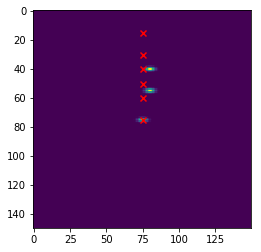

In [57]:
l(torch.tensor(predictions), boxes)

In [58]:
l = GaussianLoss(map_size=(150,150), height=1, step=1, narrow=False, plot=True)

[tensor(1.), tensor(0.0088), tensor(0.0088), tensor(0.4771), tensor(5.5903e-08), tensor(2.2421e-44)]


tensor(0.2491)

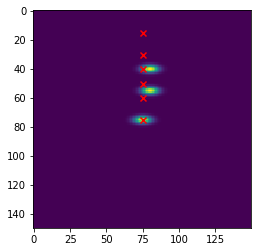

In [59]:
l(torch.tensor(predictions), boxes)

### Check out of route and out of road functions (There was a bug in RoadLoss about XY to YX)

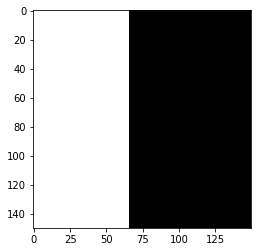

In [60]:
canvas = makeBox((150,150), (30,30), angle= 90, l=70, w=250, speed=0)/255
plt.imshow(canvas, cmap='binary_r')

In [61]:
is_outside_frame(canvas, (45,50))

False

In [62]:
is_outside_frame(canvas, (-45,50))

True

True

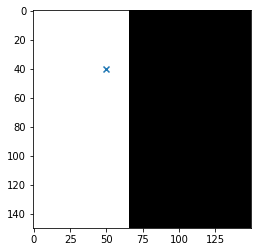

In [63]:
plt.imshow(canvas, cmap='binary_r')
plt.scatter(50,40, marker='x')
is_outside_road(canvas, (50,40))

False

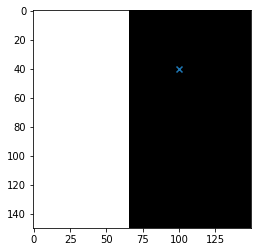

In [64]:
plt.imshow(canvas, cmap='binary_r')
plt.scatter(100,40, marker='x')
is_outside_road(canvas, (100,40))

True

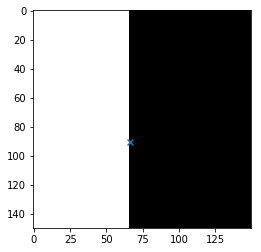

In [65]:
plt.imshow(canvas, cmap='binary_r')
plt.scatter(66,90, marker='x')
is_outside_road(canvas, (66,90))

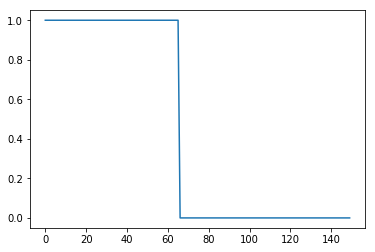

In [66]:
plt.plot(np.arange(0,canvas[0,:].shape[0]), canvas[0,:].reshape(-1))

## To do list:
    - Benchmark using fixed route loss (without -1)
    - Benchmark correcting XY order in is_out_of_road function
    - Batch implementation of Road and Gaussian functions
    - Once code is bug-free, do some hyper parameters tweaking  
    - Improve architecture 
    